#Data Processing

In [3]:
import pandas as pd
from matplotlib import pyplot
df = pd.read_csv('^NSEI_test_data_20M.csv')
df.dropna(inplace=True)
WINDOW = 30


In [4]:
df['Change'] = df['Close'].diff()
df.drop('Adj Close',axis=1,inplace=True)
display(df.head())
display(df.tail())
print('Columns are ',df.columns)
print('No. of entries ',len(df))

,Date,Open,High,Low,Close,Volume,Change
0,2022-01-03,17387.150391,17646.650391,17383.300781,17625.699219,200500,NaN
1,2022-01-04,17681.400391,17827.599609,17593.550781,17805.250000,247400,179.550781
2,2022-01-05,17820.099609,17944.699219,17748.849609,17925.250000,251500,120.000000
3,2022-01-06,17768.500000,17797.949219,17655.550781,17745.900391,236500,-179.349609
4,2022-01-07,17797.599609,17905.000000,17704.550781,17812.699219,239300,66.798828


,Date,Open,High,Low,Close,Volume,Change
407,2023-08-24,19535.150391,19584.449219,19369.000000,19386.699219,268300,-57.300781
408,2023-08-25,19297.400391,19339.550781,19229.699219,19265.800781,466500,-120.898438
409,2023-08-28,19298.349609,19366.849609,19249.699219,19306.050781,248200,40.250000
410,2023-08-29,19374.849609,19377.900391,19309.099609,19342.650391,307400,36.599610
411,2023-08-30,19433.449219,19452.800781,19334.750000,19347.449219,233000,4.798828


Columns are  Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Change'], dtype='object')
No. of entries  412


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


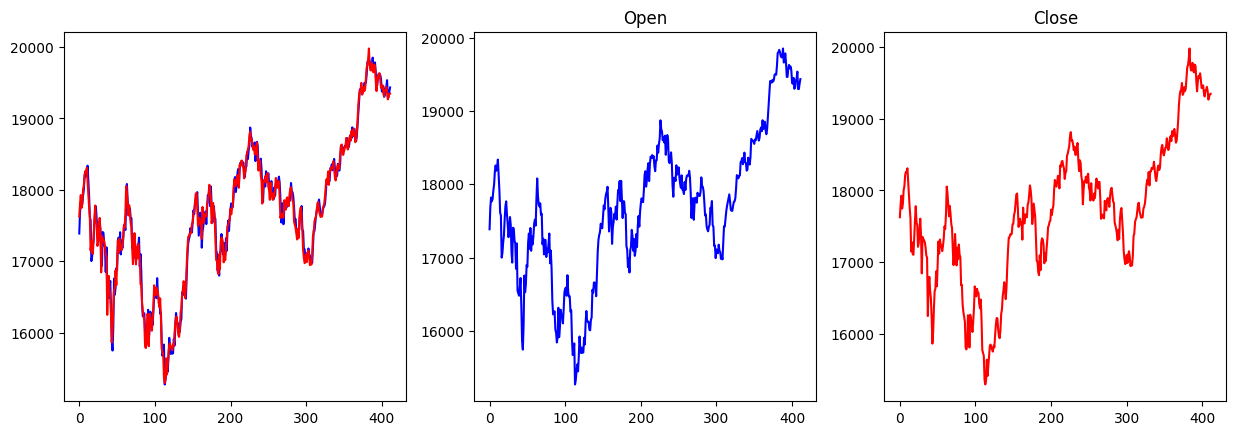

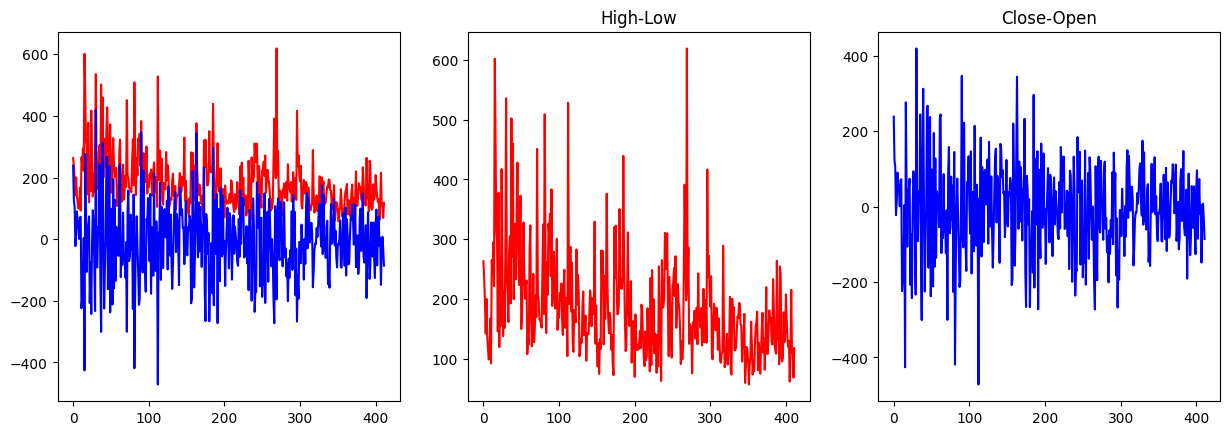

In [ ]:
fig,ax = pyplot.subplots(1,3)
fig.set_figwidth(15)
ax[0].plot(df['Open'],color='blue')
ax[0].plot(df['Close'],color='red')
ax[1].plot(df['Open'],color='blue')
ax[1].set_title('Open')
ax[2].plot(df['Close'],color='red')
ax[2].set_title('Close')
pyplot.show()
fig,ax = pyplot.subplots(1,3)
fig.set_figwidth(15)
ax[0].plot(df['High']-df['Low'],color='red')
ax[0].plot(df['Close']-df['Open'],color='blue')
ax[1].plot(df['High']-df['Low'],color='red')
ax[2].plot(df['Close']-df['Open'],color='blue')
ax[1].set_title('High-Low')
ax[2].set_title('Close-Open')
pyplot.show()

#RL Environment




In [ ]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt
import math, random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.distributions import Categorical

In [ ]:
class Actions(Enum):
    Sell = 0
    Buy = 1

class Positions(Enum):
    Short = 0
    Long = 1
    def invert(self):
        return Positions.Short if self == Positions.Long else Positions.Long

class TradingEnv(gym.Env):

    def __init__(self, df, window_size,start,stop):

        assert start>=window_size
        self.df = df
        self.window_size = window_size
        self.frame = (start,stop)
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        self.action_space = spaces.Discrete(len(Actions))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64)

        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._done = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._total_reward = None
        self._total_profit = None

    def reset(self):
        self._done = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Short
        self._total_reward = 0.
        self._total_profit = 1.
        return self._get_observation()

    def step(self, action):
        self._done = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._done = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward
        self._update_profit(action)

        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade:
            self._position = self._position.invert()
            self._last_trade_tick = self._current_tick

        observation = self._get_observation()
        data = {'total_reward': self._total_reward,'total_profit': self._total_profit,'position': self._position.value}

        if len(observation)<self.window_size:
          self._done = True
        return observation, step_reward, self._done, data

    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    def _process_data(self):
        prices = self.df['Close'].to_numpy()

        prices[self.frame[0] - self.window_size]
        prices = prices[self.frame[0]-self.window_size:self.frame[1]]

        diff = np.insert(np.diff(prices), 0, 0)
        signal_features = df[['Open','High','Low','Close','Volume','Change']].loc[self.frame[0]-self.window_size:self.frame[1]].to_numpy()

        return prices, signal_features

    def _calculate_reward(self, action):
        step_reward = 0

        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            if self._position == Positions.Long:
                step_reward += current_price - last_trade_price

        return step_reward

    def _update_profit(self, action):
        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade or self._done:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self._position == Positions.Long:
                self._total_profit = self._total_profit / last_trade_price * current_price


In [ ]:
env = TradingEnv(df,WINDOW,30,len(df)-1)

#Neural Network

In [ ]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.input_layer = nn.Linear(WINDOW*6, 16) #signal_features has 6 features
        self.l1 = nn.Linear(16,32)
        self.hidden_1 = nn.Linear(32, 64)
        self.hidden_2 = nn.Linear(64,16)
        self.action_head = nn.Linear(16, 2) #2 actions
        self.value_head = nn.Linear(16, 1) #return scalar
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        # inputs = inputs.to(torch.float32)
        x = torch.tensor(x).cuda()
        x = x.to(torch.float32)
        x = x.flatten()
        x = torch.tanh(self.input_layer(x))
        x = torch.tanh(self.l1(x))
        x = torch.tanh(self.hidden_1(x))
        x = F.relu(self.hidden_2(x))
        action_scores = self.action_head(x)
        action_scores = F.softmax(action_scores,dim=-1)

        m = Categorical(action_scores)
        best_action = m.sample()
        state_values = self.value_head(x)
        self.saved_actions.append((m.log_prob(best_action), state_values))
        return best_action, state_values

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Training and Testing

In [ ]:
model = Policy().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
gamma = 0.95
log_interval = 25


In [ ]:

def finish_episode():
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    rewards = []

    for r in model.rewards[::-1]:
        R = r + (gamma * R)
        rewards.append(R)
    rewards = torch.tensor(rewards[::-1])

    epsilon = (torch.rand(1) / 1e4) - 5e-5
    rewards += epsilon

    for (log_prob, value), r in zip(saved_actions, rewards):
        reward = torch.tensor(r - value.item()).cuda()
        policy_losses.append(-log_prob * reward)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([r]).cuda()))

    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    loss = torch.clamp(loss, -1e-5, 1e5)
    loss.backward()
    optimizer.step()
    del model.rewards[:]
    del model.saved_actions[:]

def train(EPISODES=800):
  running_reward = 0
  for episode in range(EPISODES):
      state = env.reset()
      reward = 0
      done = False
      msg = None
      while not done:
          action,_ = model.forward(state)
          state, reward, done, msg = env.step(action)
          model.rewards.append(reward)
          if done:
              reward = sum(model.rewards)
              break
      running_reward = running_reward * (1 - 1/log_interval) + reward * (1/log_interval)
      if episode % log_interval == 0:
          print(f"""Episode {episode} ; Running reward {running_reward}""")
          pyplot.plot(model.rewards)
          pyplot.show()
      finish_episode()
      print(f"""Episode {episode} ; Episode Reward {reward} ; Total Profit % {(env._total_profit-1)*100} ; Running reward {running_reward}""")
  return float(env._total_profit-1)*100


Episode 0 ; Running reward 21.101874959999986


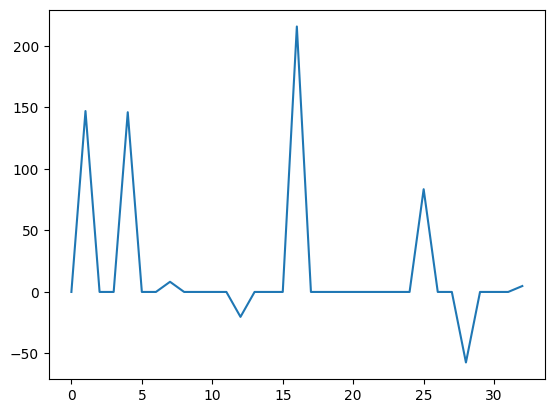

Episode 0 ; Episode Reward 527.5468739999997 ; Total Profit % 2.724973568767708 ; Running reward 21.101874959999986


<ipython-input-119-f117f667d85e>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reward = torch.tensor(r - value.item()).cuda()


Episode 0 ; Running reward -1.27


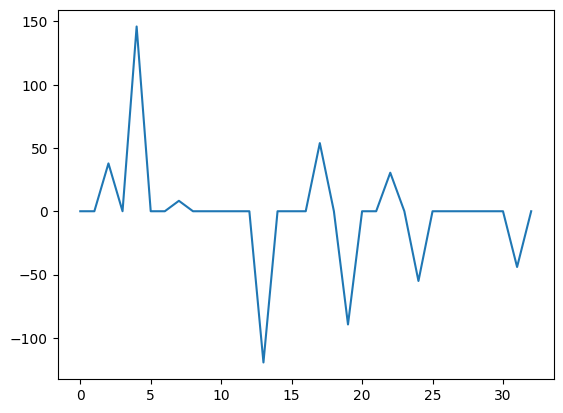

Episode 0 ; Episode Reward -31.75 ; Total Profit % -0.1799872551156212 ; Running reward -1.27
Episode 0 ; Running reward 4.433984360000031


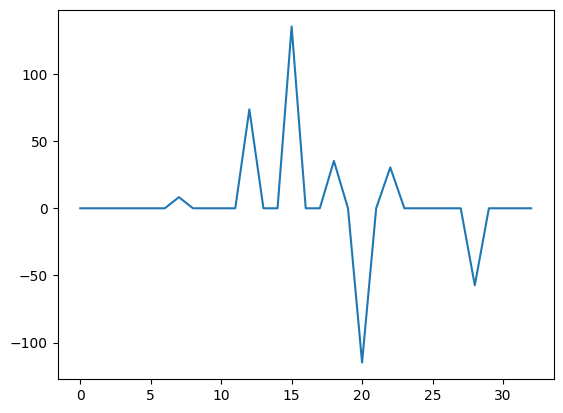

Episode 0 ; Episode Reward 110.84960900000078 ; Total Profit % 0.5653405630455799 ; Running reward 4.433984360000031
Episode 0 ; Running reward 10.567968720000064


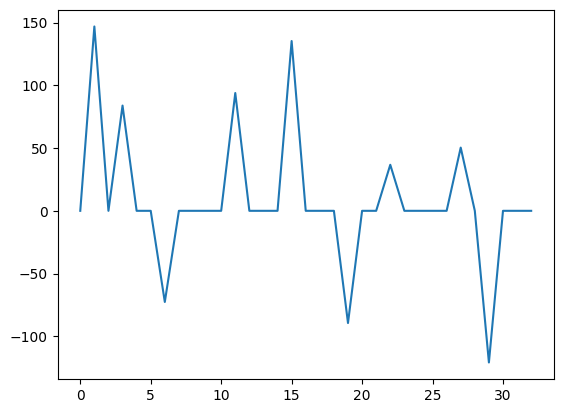

Episode 0 ; Episode Reward 264.19921800000157 ; Total Profit % 1.351071516616975 ; Running reward 10.567968720000064
Episode 0 ; Running reward 8.606093760000077


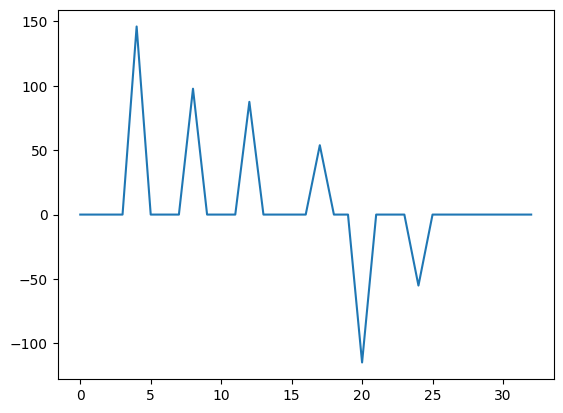

Episode 0 ; Episode Reward 215.1523440000019 ; Total Profit % 1.5086673875164491 ; Running reward 8.606093760000077
Episode 0 ; Running reward -16.785937479999994


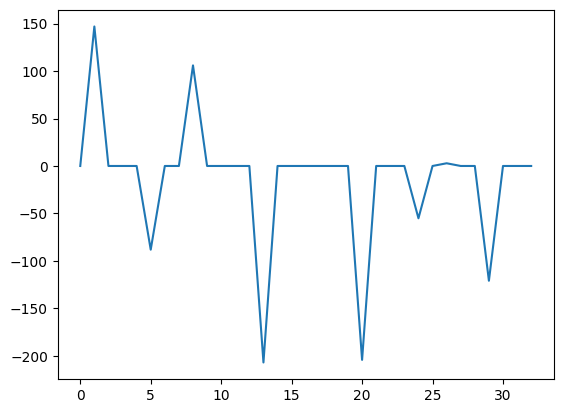

Episode 0 ; Episode Reward -419.64843699999983 ; Total Profit % -2.1330813764247503 ; Running reward -16.785937479999994
Episode 0 ; Running reward 11.8139843999999


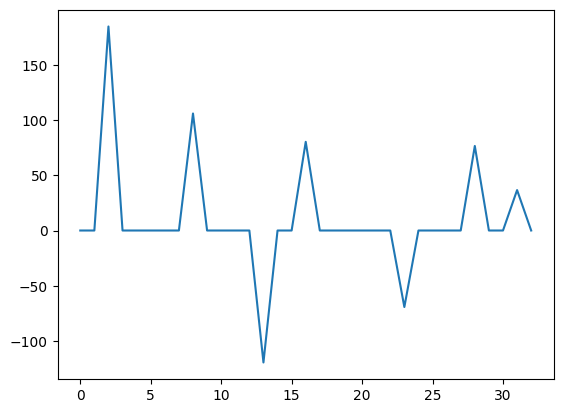

Episode 0 ; Episode Reward 295.3496099999975 ; Total Profit % 1.5166837220704332 ; Running reward 11.8139843999999
Episode 0 ; Running reward -22.41007808000024


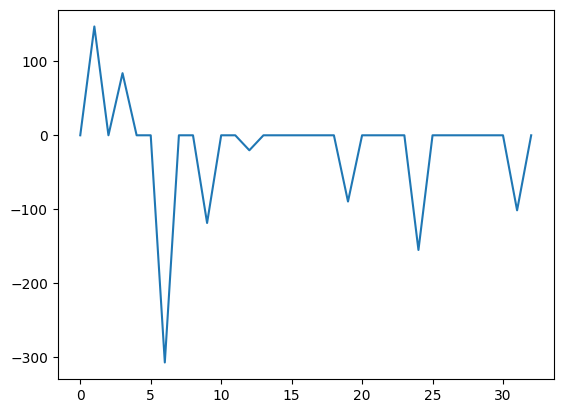

Episode 0 ; Episode Reward -560.251952000006 ; Total Profit % -2.815868989079795 ; Running reward -22.41007808000024
Episode 0 ; Running reward -13.675937479999993


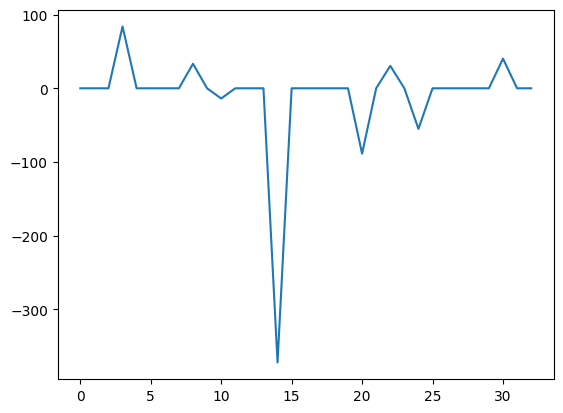

Episode 0 ; Episode Reward -341.89843699999983 ; Total Profit % -1.7398196820077705 ; Running reward -13.675937479999993
Episode 0 ; Running reward 12.087968759999931


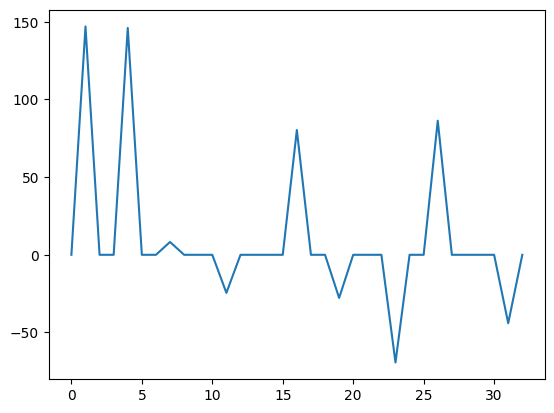

Episode 0 ; Episode Reward 302.19921899999827 ; Total Profit % 1.5414003530307196 ; Running reward 12.087968759999931
EVALUATION
TESTS : 10 
RESULTS : [2.724973568767708, -0.1799872551156212, 0.5653405630455799, 1.351071516616975, 1.5086673875164491, -2.1330813764247503, 1.5166837220704332, -2.815868989079795, -1.7398196820077705, 1.5414003530307196]
AVG PnL : 0.23393798084199288
MAX PnL : 2.724973568767708
MIN PnL : -2.815868989079795
STD PnL : 1.7752199712769718



In [ ]:
# train()
# torch.save(model.state_dict(),'model.pt')
model.load_state_dict(torch.load('model.pt'))
model.eval()
df_test = pd.read_csv('^NSEI_test_data.csv')
df_test.dropna(inplace=True)
env = TradingEnv(df_test,WINDOW,30,len(df)-1)
TESTS = 10
res = []
for _ in range(TESTS):
  res.append(train(1))
print(f'''EVALUATION
TESTS : {TESTS}
RESULTS : {res}
AVG PnL : {sum(res)/len(res)}
MAX PnL : {max(res)}
MIN PnL : {min(res)}
STD PnL : {np.std(res)}
''')

#ARIMA

In [10]:
import statsmodels.api as sm
import numpy as np
from tqdm import tqdm
df_test = pd.read_csv('^NSEI_test_data.csv')
df_test.dropna(inplace=True)
dataset = df_test
returns = (dataset['Close']/dataset['Open']-1)
prices = (dataset['Open']+dataset['Close'])/2

def ARIMA(order, thresh, returns=returns, prices=prices, amt=1):

    curr_holding = False
    events_list = []
    init_amt = amt

    for date, r in tqdm (returns[20:].items(), total=len(returns[20:])):
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))
            continue
        curr_data = returns[:date]
        if type(order) == tuple:
            model = sm.tsa.ARIMA(curr_data, order=order).fit()
            pred = model.forecast()[date]

        if (not curr_holding) and ((type(order) == float and np.random.random() < order) or (type(order) == tuple and pred > thresh) or (order == 'last' and curr_data[-1] > 0)):

            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
    print(events_list)
    return amt

ret = ARIMA((15,0,5), 0.001)
print('\n\n')
print('PnL',(ret-1)*100)

  0%|          | 0/44 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|▏         | 1/44 [00:02<01:55,  2.68s/it]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood o

[('b', 24), ('s', 25, 0.0020242725404162397), ('b', 27), ('s', 28, 0.0028447024673439766), ('b', 30), ('s', 31, 0.0038294531975497396), ('b', 34), ('s', 35, 0.004408859643593978), ('b', 37), ('s', 38, -0.00027522552364644547), ('b', 42), ('s', 43, 0.002470827483821671), ('b', 44), ('s', 45, -0.008589433934073763), ('b', 46), ('s', 47, 0.004985905651286361), ('b', 49), ('s', 50, -0.0015990566379957456), ('b', 52), ('s', 53, 0.0003992941509847109), ('b', 56), ('s', 57, 0.002564916742543096), ('b', 59), ('s', 60, -0.009214578484673318), ('b', 63)]



PnL 0.3733866245475559
